In [1]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SpectralCoord
barycorrlist=[]
sc_nm_list = []
sc_kms_list = []
mjd=[]
ltt_barylist=[]
bjdlist = []
for i in range(1, 22):
    hdul=fits.open(f'VIS_{i:02}.fits')
    mjd.append(hdul[0].header['MJD-OBS'])
    
for i in range(1, 22):
    file = f'VIS_{i:02}.fits'
    hdul = fits.open(file)
    flux_data = hdul[0].data
    header = hdul[0].header
    exposuretime = header['EXPTIME']
    start_wavelength_nm = header['CRVAL1']
    wavelength_step_nm = header['CDELT1']
    pixel_num = np.arange(len(flux_data))
    wavelength_nm = start_wavelength_nm + (pixel_num * wavelength_step_nm)
    sc = SpectralCoord(wavelength_nm, unit='nm')
    sc_kms = sc.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    sc_nm_list.append(sc)
    sc_kms_list.append(sc_kms)
    
    from astropy import time, coordinates as coord, units as u
    VIS = coord.SkyCoord("21:21:18.6", "-09:43:29.0", unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+((exposuretime/2) / 86400.0)], format='mjd', scale='utc', location=paranal)
    barycorr = VIS.radial_velocity_correction(obstime=times)
    barycorrlist.append(barycorr)
    ltt_bary = times.light_travel_time(VIS)
    ltt_barylist.append(ltt_bary)
    time_barycentre = times.tdb + ltt_bary.value.item()
    bjdlist.append(time_barycentre)

    
bary_kmslist = []
for i in range (1,22):
    bary_nm = sc_nm_list[i-1].with_radial_velocity_shift(barycorrlist[i-1])
    bary_kms = bary_nm.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    bary_kmslist.append(bary_kms)


In [3]:
c = 2.998e5
def compute_trailing_data(file_list, bary_kmslist, binsize):
    common_velocity_axis = np.arange((-c*(6562.76-5465))/6562.76, ((c*(10000-6562.76))/6562.76)+binsize, binsize)
    resampled_flux_list = []
    
    for i, fitfile in enumerate(file_list):
        hdul = fits.open(fitfile)
        flux_data = hdul[0].data    
        original_velocity_axis = bary_kmslist[i]
        f = scipy.interpolate.interp1d(original_velocity_axis, flux_data, kind='cubic', bounds_error=False, fill_value=np.nan)
        resampled_flux = f(common_velocity_axis)
        resampled_flux_list.append(resampled_flux)

    trailing_data = np.array(resampled_flux_list)
    return trailing_data, common_velocity_axis


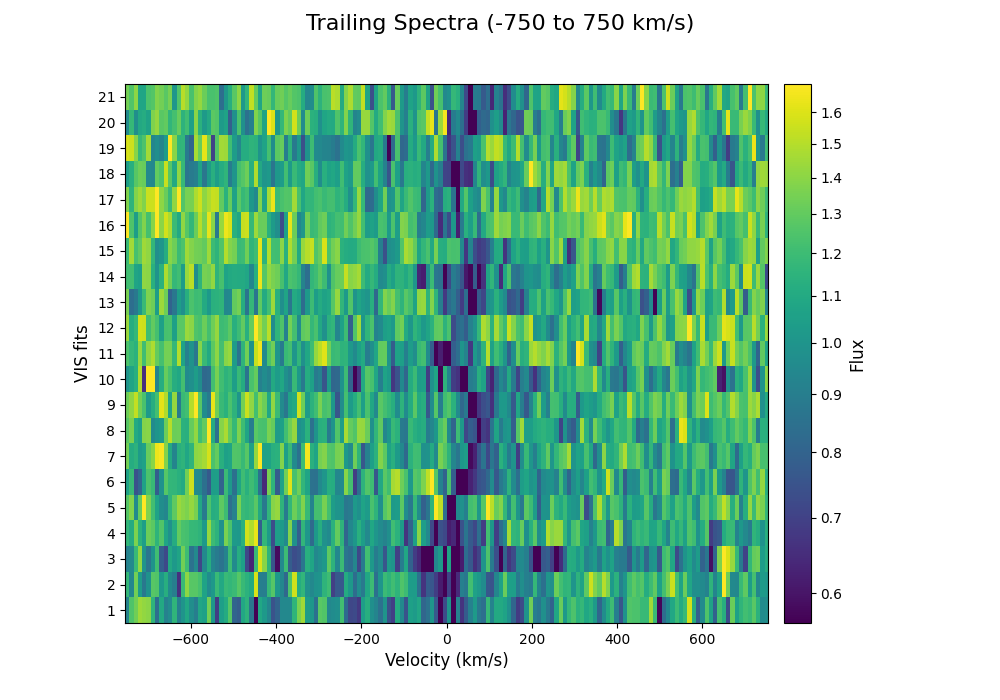

In [39]:
import scipy
from matplotlib import colors
def plot_trailing_spectra(file_list, bary_kmslist, min_v, max_v, binsize):
    %matplotlib widget
    trailing_data, common_velocity_axis = compute_trailing_data(file_list, bary_kmslist, binsize)
    n_files = len(trailing_data)

    median_flux = np.median(trailing_data)
    
    normalised_trailing_data = trailing_data/median_flux
    velocitymask = (common_velocity_axis > min_v) & (common_velocity_axis < max_v)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocitymask]
    vmin = 0.5 * np.median(normalised_trailing_data_masked)
    vmax = 1.5 * np.median(normalised_trailing_data_masked)
    
    fig, ax = plt.subplots(figsize=(10,7))
    im = ax.imshow(normalised_trailing_data_masked, interpolation='nearest', extent=[min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5],
                   origin='lower', aspect='auto', norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='viridis')

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Flux', fontsize=12)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar.set_ticklabels(formatted_ticks)
 
    ax.set_xlabel('Velocity (km/s)', fontsize=12)
    ax.set_ylabel('VIS fits', fontsize=12)
    plt.suptitle(f'Trailing Spectra ({min_v} to {max_v} km/s)', fontsize=16)

    ax.set_yticks(np.arange(1, n_files + 1))
    plt.savefig('trailing_spectra.png', dpi=300, bbox_inches='tight')
    plt.show()
  
fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
plot_trailing_spectra(fits_files, bary_kmslist, -750, 750, 10)

/tmp/ipykernel_99982/1405194476.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


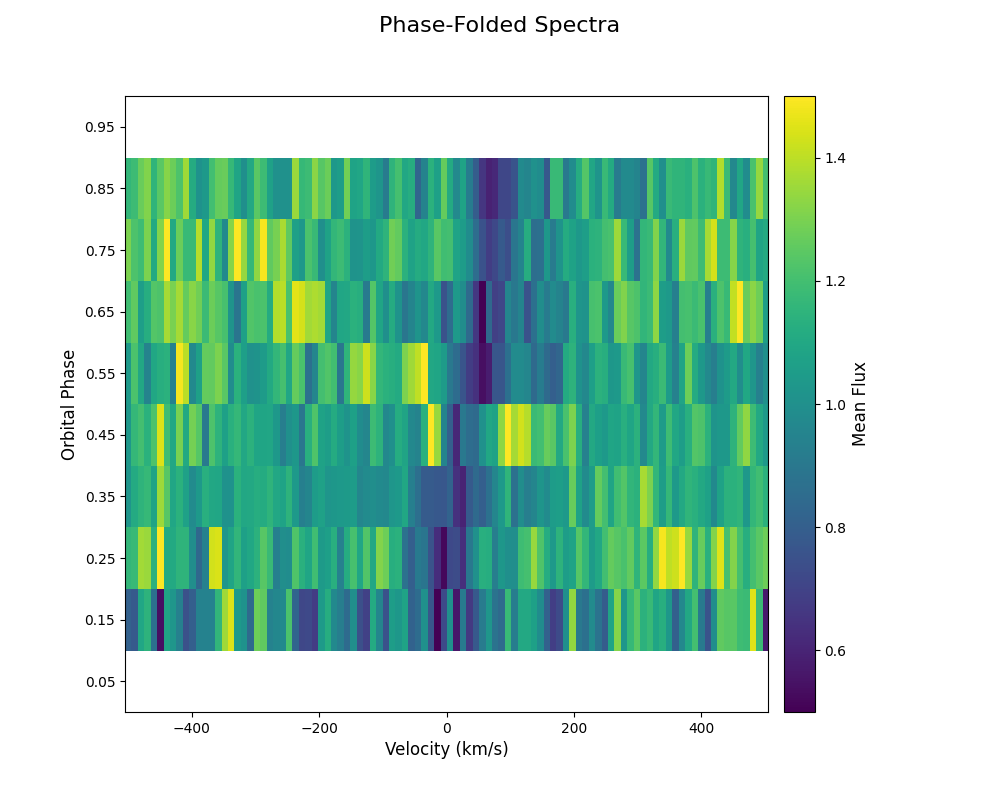

In [6]:
def orbitalphasefunc():
    T0_val = 59385.541376
    P = 0.0953979016
    T0 = time.Time(T0_val, format='mjd', scale='tdb')
    orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]
    return orbitalphase

def plot_orbitalphase_spectra(file_list, bary_kmslist, min_v, max_v, binsize, phase_bin_size):
    %matplotlib widget
    trailing_data, common_velocity_axis = compute_trailing_data(file_list, bary_kmslist, binsize)
    n_files = len(trailing_data)

    median_flux = np.median(trailing_data)
    
    normalised_trailing_data = trailing_data/median_flux
    vmin = 0.5 * np.median(normalised_trailing_data)
    vmax = 1.5 * np.median(normalised_trailing_data)
    velocitymask = (common_velocity_axis > min_v) & (common_velocity_axis < max_v)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocitymask]
    
    phase_bins = np.arange(0.0, 1.0, phase_bin_size)
    binned_spectra_list = []
    orbitalphase = orbitalphasefunc()

    for start_phase in phase_bins:
        end_phase = start_phase + phase_bin_size
        phase_mask = (np.array(orbitalphase) >= start_phase) & (np.array(orbitalphase) < end_phase)
        fluxes_in_bin = normalised_trailing_data_masked[phase_mask]

        if fluxes_in_bin.shape[0] > 0:
            mean_flux_for_bin = np.mean(fluxes_in_bin, axis=0)
        else:
            mean_flux_for_bin = np.full(len(common_velocity_axis[velocitymask]), np.nan)

        binned_spectra_list.append(mean_flux_for_bin)

    phase_data = np.ma.masked_invalid(np.array(binned_spectra_list))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(phase_data, extent=[min_v - binsize / 2, max_v + binsize / 2, 0, 1],
                   origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Mean Flux', fontsize=12)

    ax.set_xlabel('Velocity (km/s)', fontsize=12)
    ax.set_ylabel('Orbital Phase', fontsize=12)
    plt.suptitle('Phase-Folded Spectra', fontsize=16)

    ax.set_yticks(phase_bins + phase_bin_size / 2)
    ax.set_yticklabels([f'{p:.2f}' for p in phase_bins + phase_bin_size / 2])
    plt.show()

fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
plot_orbitalphase_spectra(fits_files, bary_kmslist, -500, 500, 10, 0.1)

/tmp/ipykernel_99982/1405194476.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


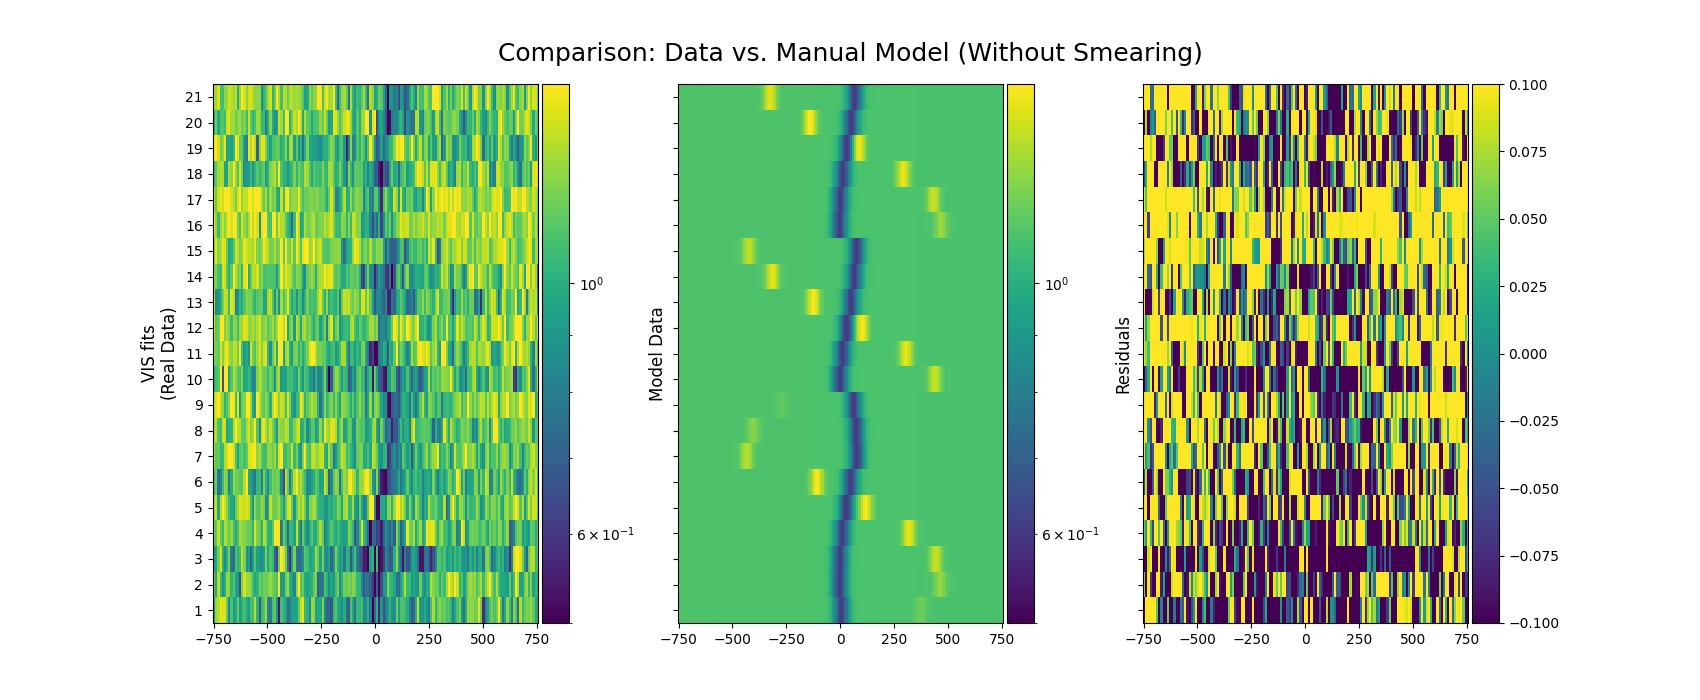

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.modeling import models
#import the fit files
fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
min_v, max_v, binsize = -750, 750, 10
trailing_data, common_velocity_axis = compute_trailing_data(fits_files, bary_kmslist, binsize)
velocitymask = (common_velocity_axis > min_v) & (common_velocity_axis < max_v)

#modified function to return flux arrays instead of plotting

def plot_trailing_spectra_modified(file_list, bary_kmslist, min_v, max_v, binsize):
    n_files = len(trailing_data)

    median_flux = np.median(trailing_data)
    
    normalised_trailing_data = trailing_data/median_flux
    vmin = 0.5 * np.median(normalised_trailing_data)
    vmax = 1.5 * np.median(normalised_trailing_data)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocitymask]
 
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    plot_extent = [min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5]
   
    fig, axes = plt.subplots(1,3, figsize=(17, 7), sharex=True, sharey=True,
                             gridspec_kw={'hspace': 0.15})
    fig.suptitle('Comparison: Data vs. Manual Model (Without Smearing)', fontsize=18, y=0.94)

    im1 = axes[0].imshow(normalised_trailing_data_masked, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')

    axes[0].set_ylabel('VIS fits\n(Real Data)', fontsize=12)
    axes[0].set_yticks(np.arange(1, n_files + 1))
    cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.01)
    #cbar1.set_label('Flux', fontsize=12)
    
    return fig, axes, normalised_trailing_data_masked, norm, plot_extent

#function of the model
def generate_model_data(orbitalphase, 
                        gamma_wd, k_wd, wd_amp, wd_std, 
                        gamma_bd, k_emis, bd_amp, bd_std, 
                        slope, intercept):
    model_spectra_list = []
    for phase in orbitalphase:
        linear_background = models.Linear1D(slope=slope, intercept=intercept)

        # White Dwarf (WD) Absorption Line Model
        # The mean velocity varies sinusoidally with the orbital phase
        mean_wd = gamma_wd - k_wd * np.sin(2 * np.pi * phase)
        gauss_wd = models.Gaussian1D(amplitude=wd_amp, mean=mean_wd, stddev=wd_std)

        # Brown Dwarf (BD) Irradiated Emission Line Model
        mean_bd = gamma_bd + k_emis * np.sin(2 * np.pi * phase)
        # The amplitude varies due to irradiation, peaking at phase 0.5 (BD is "behind the WD").
        amplitude_bd = -bd_amp * (1 - np.cos(2 * np.pi * phase)) / 2.0
        gauss_bd = models.Gaussian1D(amplitude=amplitude_bd, mean=mean_bd, stddev=bd_std)
        
        composite_model = linear_background + gauss_wd + gauss_bd

        model_flux = composite_model(common_velocity_axis[velocitymask])
        model_spectra_list.append(model_flux)

    return np.array(model_spectra_list)
    

#function of comparison plots
def plot_comparison():

    fig, axes, real_data, data_norm, plot_extent= \
        plot_trailing_spectra_modified(fits_files, bary_kmslist, min_v, max_v, binsize)

    manual_model_params = {
        'gamma_wd': 30.0, 'k_wd': 40.0, 'wd_amp': -0.50, 'wd_std': 25.0,
        'gamma_bd': 10.0, 'k_emis': 450.0, 'bd_amp': -0.4, 'bd_std': 20.0,
        'slope': -0.00001, 'intercept': 1.1 }
    
    orbital_phases = orbitalphasefunc()
    model_data = generate_model_data(orbital_phases, **manual_model_params)

    im2 = axes[1].imshow(model_data, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=data_norm, cmap='viridis')
    axes[1].set_ylabel('Model Data', fontsize=12)
    cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.01)
 
    residual = real_data - model_data
    res_norm = colors.Normalize(vmin=-0.1, vmax=0.1)
    
    im3 = axes[2].imshow(residual, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=res_norm, cmap='viridis')
    cbar3 = fig.colorbar(im3, ax=axes[2], pad=0.01)
    axes[2].set_ylabel('Residuals', fontsize=12)
    
    plt.show()
    plt.savefig("comparison.png")

plot_comparison()

/tmp/ipykernel_99982/1405194476.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


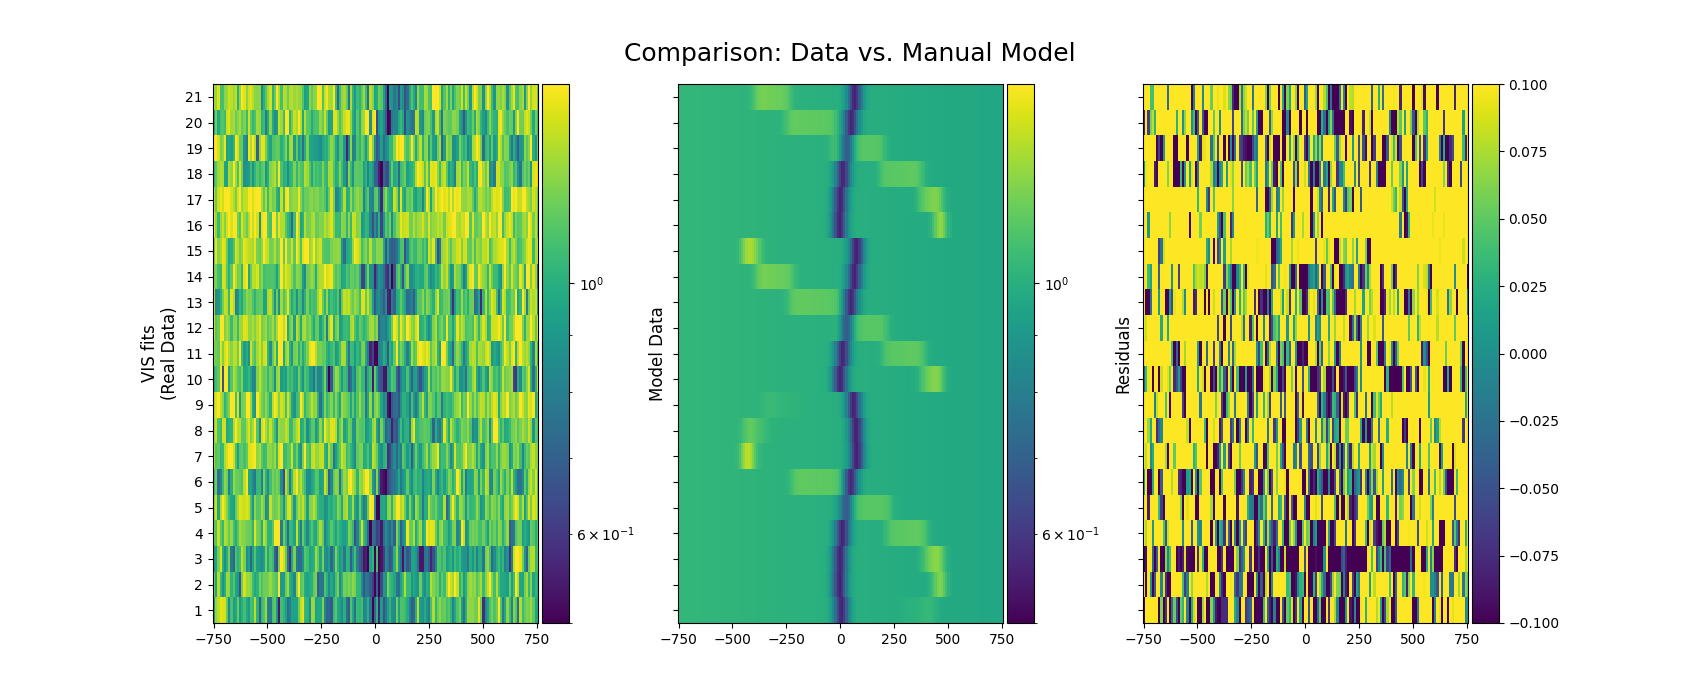

In [35]:
#import the fit files
fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
min_v, max_v, binsize = -750, 750, 10
velocity_mask = (common_velocity_axis >= min_v) & (common_velocity_axis <= max_v)

#modified function to return flux arrays instead of plotting
def plot_trailing_spectra_modified(file_list, bary_kmslist, min_v, max_v, binsize):
    n_files = len(trailing_data)
    median_flux = np.median(trailing_data)
    normalised_trailing_data = trailing_data/median_flux
    vmin = 0.5 * np.median(normalised_trailing_data)
    vmax = 1.5 * np.median(normalised_trailing_data)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocitymask]

    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    plot_extent = [min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5]
   
    fig, axes = plt.subplots(1,3, figsize=(17, 7), sharex=True, sharey=True,
                             gridspec_kw={'hspace': 0.15})
    fig.suptitle('Comparison: Data vs. Manual Model', fontsize=18, y=0.94)

    im1 = axes[0].imshow(normalised_trailing_data_masked, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')

    axes[0].set_ylabel('VIS fits\n(Real Data)', fontsize=12)
    axes[0].set_yticks(np.arange(1, n_files + 1))
    cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.01)
    #cbar1.set_label('Flux', fontsize=12)
    
    return fig, axes, normalised_trailing_data_masked, norm, plot_extent
    
#function of model with smearing effects   
def generate_model_data(orbitalphase, common_velocity_axis, P_orb_days,
                        gamma_wd, k_wd, wd_amp, wd_std,
                        gamma_bd, k_emis, bd_amp, bd_std,
                        slope, intercept,
                        exposure_time_s=600.0, n_bins=6):
    """
    Generates model spectra including the orbital smearing effect.
    """
    model_spectra_list = []

    # Calculate the phase change for each time bin within the exposure
    time_offsets = np.linspace(-exposure_time_s / 2.0, exposure_time_s / 2.0, n_bins)
    phase_offsets = time_offsets / (P_orb_days * 86400.0) 

    # Loop through each observation's mid-exposure phase
    for mid_phase in orbitalphase:
        sub_spectra = []
        
        # For each mid-phase, calculate the model at each time bin
        for offset in phase_offsets:
            current_phase = mid_phase + offset

            # --- The rest of your model calculation is the same ---
            linear_background = models.Linear1D(slope=slope, intercept=intercept)

            mean_wd = gamma_wd - k_wd * np.sin(2 * np.pi * current_phase)
            gauss_wd = models.Gaussian1D(amplitude=wd_amp, mean=mean_wd, stddev=wd_std)

            mean_bd = gamma_bd + k_emis * np.sin(2 * np.pi * current_phase)
            amplitude_bd = -bd_amp * (1 - np.cos(2 * np.pi * current_phase)) / 2.0
            gauss_bd = models.Gaussian1D(amplitude=amplitude_bd, mean=mean_bd, stddev=bd_std)
            
            composite_model = linear_background + gauss_wd + gauss_bd
            model_flux_for_bin = composite_model(common_velocity_axis[velocitymask])
            sub_spectra.append(model_flux_for_bin)

        # Average the binned spectra to create the final, smeared spectrum
        smeared_spectrum = np.mean(sub_spectra, axis=0)
        model_spectra_list.append(smeared_spectrum)

    return np.array(model_spectra_list)

def plot_comparison():
    fig, axes, real_data, data_norm, plot_extent = \
        plot_trailing_spectra_modified(trailing_data, common_velocity_axis[velocitymask], min_v, max_v, binsize)

    manual_model_params = {
        'gamma_wd': 30.0, 'k_wd': 40.0, 'wd_amp': -0.45, 'wd_std': 25.0,
        'gamma_bd': 10.0, 'k_emis': 450.0, 'bd_amp': -0.65, 'bd_std': 20.0,
        'slope': -0.00005, 'intercept': 1.0
    }
    orbitalphase = orbitalphasefunc() # Your original function call
    P = 0.0953979016
    model_data = generate_model_data(
        orbitalphase,
        common_velocity_axis,
        P_orb_days=P,
        **manual_model_params)

    im2 = axes[1].imshow(model_data, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=data_norm, cmap='viridis')
    axes[1].set_ylabel('Model Data', fontsize=12)
    cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.01)
 
    residual = real_data - model_data
    res_norm = colors.Normalize(vmin=-0.1, vmax=0.1)
    
    im3 = axes[2].imshow(residual, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=res_norm, cmap='viridis')
    cbar3 = fig.colorbar(im3, ax=axes[2], pad=0.01)
    axes[2].set_ylabel('Residuals', fontsize=12)
    
    plt.show()
    plt.savefig("comparison.png")


plot_comparison()